In [5]:
import torchvision
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

import os
from collections import namedtuple, OrderedDict
import numpy as np
from skimage import io

import pyro
import pyro.optim as optim
# from pyro.infer import SVI, TraceGraph_ELBO
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate
import pyro.distributions as dist
import pyro.poutine as poutine
# import pyro.contrib.examples.multi_mnist as multi_mnist
import torch
import torch.nn as nn
from torch.nn.functional import relu, tanh, sigmoid, softplus, grid_sample, affine_grid, avg_pool2d
from torch.distributions.bernoulli import Bernoulli

import pandas as pd
import matplotlib.pyplot as plt

from sympy.solvers import solve
from sympy import Symbol, var
from sympy.solvers.diophantine import diophantine
from sympy.solvers.diophantine.diophantine import diop_solve
from sympy.solvers.diophantine.diophantine import diop_ternary_quadratic

import visdom

import seaborn as sns
import math
# from torch.linalg import matrix_exp

from tqdm import tqdm, trange

In [6]:
# from __future__ import print_function
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.autograd import Variable

# def sample_gumbel(shape, eps=1e-20):
#     U = torch.rand(shape).cuda()
#     return -Variable(torch.log(-torch.log(U + eps) + eps))

# def gumbel_softmax_sample(logits, temperature):
#     y = logits + sample_gumbel(logits.size())
#     return F.softmax(y / temperature, dim=-1)

# def gumbel_softmax(logits, temperature):
#     """
#     input: [*, n_class]
#     return: [*, n_class] an one-hot vector
#     """
#     y = gumbel_softmax_sample(logits, temperature)
#     shape = y.size()
#     _, ind = y.max(dim=-1)
#     y_hard = torch.zeros_like(y).view(-1, shape[-1])
#     y_hard.scatter_(1, ind.view(-1, 1), 1)
#     y_hard = y_hard.view(*shape)
#     return (y_hard - y).detach() + y

# if __name__ == '__main__':
#     import math
#     print(gumbel_softmax(Variable(torch.cuda.FloatTensor([[math.log(0.1), math.log(0.4), math.log(0.3), math.log(0.2)]] * 20000)),     0.8).sum(dim=0))

In [7]:
torch.pi = torch.acos(torch.zeros(1)).item() * 2

torch.pi

device = torch.device('cuda:0')

torch.set_default_dtype(torch.float64)

# vis = visdom.Visdom()

In [8]:
torch.cuda.is_available()

True

In [9]:
train = torchvision.datasets.MNIST(root="./dataset", train=True, download=True, transform=ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



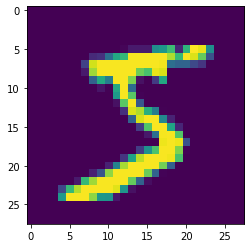

In [10]:
plt.imshow(train[0][0][0])

In [11]:
n_vector = 28*28
n_class = 10

In [12]:
vectors_ = []
labels_ = []
for v, l in train:
    vectors_.append(v)
    labels_.append(l)

vectors = torch.stack(vectors_)

vectors = vectors.reshape(-1, n_vector)

vectors = torch.tensor(vectors, dtype=torch.float64)

labels = torch.tensor(labels_)

labels = torch.nn.functional.one_hot(labels)
labels = torch.tensor(labels, dtype=vectors.dtype)

/home/lachlan/miniconda3/envs/eca/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/home/lachlan/miniconda3/envs/eca/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


In [13]:
vectors -= torch.mean(vectors, dim=0, keepdim=True)
# vectors -= 0.5
vectors /= torch.norm(vectors, dim=-1, keepdim=True)

In [14]:
category_theta = torch.softmax(torch.tensor([0.]).expand(1, n_class), dim=1)
category_theta

tensor([[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000]])

In [15]:
# pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(5)))

In [16]:
n_class

10

In [17]:
# def prior(n):
    
#     # category = pyro.sample("category", dist.Categorical(
#     #         category_theta.expand(n, n_class),
#     #     ).to_event(1)
#     # ).cuda(device=device)
    
#     # print(category_theta)
    
#     # category = pyro.sample("category", dist.DirichletMultinomial(
#     #         category_theta.expand(n, n_class),
#     #     ).to_event(0)
#     # ).cuda(device=device)
    
#     category = pyro.sample("category", dist.OneHotCategorical(
#             category_theta.expand(n, n_class),
#         ).to_event(0)
#     ).to(device=device)
    
#     # category = category_theta.expand(n, n_class).to(device=device)

#     # print(category)
#     # print("category: ", category.shape)
    
#     return category

In [18]:
# testtest = prior(8)

In [19]:
torch.rand(3).sum(axis=-1)

tensor(0.9970)

In [20]:
class UL(nn.Module):
    def __init__(self, use_cuda=True, *args, **kargs):
        super().__init__(*args, **kargs)
        n_triu = n_vector * (n_vector + 1) // 2

        # MxM
        A = torch.Tensor(n_triu)
        # A = torch.randn(n_triu)
        self.A = nn.Parameter(A) # nn.Parameter is a Tensor that's a module parameter.
        
        L_theta = torch.Tensor(n_vector, n_class)
        # L_theta = torch.rand(n_vector, n_class)
        self.L_theta = nn.Parameter(L_theta)
        
        # M_theta = torch.Tensor(n_vector, n_class)
        # L_theta = torch.rand(n_vector, n_class)
        # self.M_theta = nn.Parameter(M_theta)
        
        nn.init.uniform_(self.A, -1., 1.)
        nn.init.uniform_(self.L_theta, -1., 1.)
        # nn.init.uniform_(self.M_theta, -1., 1.)
        
        self.cuda()
        
    def forward(self, vectors):
        
        ## reconstruction
        y, x = torch.triu_indices(n_vector, n_vector)
        U = torch.zeros((n_vector, n_vector)).to(device=device)
        U.index_put_(
            [
                y,
                x
            ],
            self.A
        )
        U = U - U.T + torch.diag(torch.diagonal(U))
        U = torch.matrix_exp(U)
        U = U / torch.linalg.norm(U, dim=0)
        
        
        # MxL
        L_theta = sigmoid(self.L_theta)*(1-2e-10) + 1e-10
        L_dist = Bernoulli(L_theta)
        L = L_dist.sample().to(device=device)
        L = (L - L_theta).detach() + L_theta
        
        L_regularizer = L.sum(dim=-1)
        L_loss = torch.pow(L_regularizer - 1, 2).mean()



        P = torch.matmul(vectors, U)
        
        
        
        PP = torch.pow(P, 2)
        # NxM, MxL -> NxL
        y_prob = torch.matmul(PP, L)
        y_pred = nn.functional.gumbel_softmax(y_prob, tau=1, hard=True, dim=-1)
        
        # NxL * LxM -> NxM
        activation = torch.matmul(y_pred, L.T)
        
        
        
        
        coeff_mean = torch.matmul(y_pred, torch.sqrt(L_theta.T)) #* P / torch.abs(P)
        coeff_sampled = coeff_mean + dist.Normal(torch.zeros_like(P), torch.ones_like(P)*0.01).sample()
        # coeff_sampled = ( dist.Normal(coeff_mean, torch.ones_like(P)*0.01).rsample() + dist.Normal(-coeff_mean, torch.ones_like(P)*0.01).rsample() )/2
        # coeff_sampled = dist.Normal(coeff_mean, torch.ones_like(P)*0.01).rsample()
        coefficients = coeff_sampled * activation
        coefficients_norm = torch.linalg.norm(coefficients, dim=-1, keepdim=True)
        # coefficients = coefficients / torch.maximum(coefficients_norm, torch.tensor(1e-10).to(device=device))
        coefficients = coefficients / coefficients_norm
        
        recon = torch.matmul(coefficients, U.T)
    
        
        # dominant = nn.functional.gumbel_softmax(P, tau=1, hard=True, dim=-1)

        # recon = torch.matmul(dominant, U.T)

        
        return recon, activation, PP, L_loss
        
        
        

    
        

In [21]:
ul = UL()

In [22]:
torch.maximum(torch.rand(3), torch.tensor(0.5))

tensor([0.5000, 0.5000, 0.5000])

In [23]:
# predict the category
class PredictCategory(nn.Module):
    def __init__(self, use_cuda=True, *args, **kargs):
        super().__init__(*args, **kargs)
        
        self.l1 = nn.Linear(n_vector, 1024)
        self.l2 = nn.Linear(1024, 512)
        self.l3 = nn.Linear(512, 256)
        self.l4 = nn.Linear(256, 128)
        self.l5 = nn.Linear(128, 64)
        self.l6 = nn.Linear(64, 32)
        self.l7 = nn.Linear(32, 16)
        self.l8 = nn.Linear(16, n_class)
        
        
        
        if use_cuda:
            self.cuda(device=device)

    def forward(self, vectors):

        h = self.l1(vectors)
        h = tanh(h)
        h = self.l2(h)
        h = tanh(h)
        h = self.l3(h)
        h = tanh(h)
        h = self.l4(h)
        h = tanh(h)
        h = self.l5(h)
        h = tanh(h)
        h = self.l6(h)
        h = tanh(h)
        h = self.l7(h)
        h = tanh(h)
        h = self.l8(h)
        
        # h = torch.softmax(h, -1)
       
        return h

In [24]:
# predict the category
class PredictAffine(nn.Module):
    def __init__(self, use_cuda=True, *args, **kargs):
        super().__init__(*args, **kargs)
        
        self.l1 = nn.Linear(n_vector, 1024)
        self.l2 = nn.Linear(1024, 512)
        self.l3 = nn.Linear(512, 256)
        self.l4 = nn.Linear(256, 128)
        self.l5 = nn.Linear(128, 64)
        self.l6 = nn.Linear(64, 32)
        self.l7 = nn.Linear(32, 16)
        self.l8 = nn.Linear(16, 6)
        
        
        
        if use_cuda:
            self.cuda(device=device)

    def forward(self, vectors):
    
        n = vectors.size(0)
    
        h = self.l1(vectors)
        h = tanh(h)
        h = self.l2(h)
        h = tanh(h)
        h = self.l3(h)
        h = tanh(h)
        h = self.l4(h)
        h = tanh(h)
        h = self.l5(h)
        h = tanh(h)
        h = self.l6(h)
        h = tanh(h)
        h = self.l7(h)
        h = tanh(h)
        h = self.l8(h)
        
        h = tanh(h)
        
        # h = h.view(-1, 2, 3)

        # base = tanh(h[..., 0:2]) * 2
        # translation = tanh(h[..., 2:3])

        # h = torch.cat([base, translation], dim=-1).view(-1, 6)
        # h = torch.softmax(h, -1)

        return h

In [25]:
# # predict the category
# class Baseline(nn.Module):
#     def __init__(self, use_cuda=True, *args, **kargs):
#         super().__init__(*args, **kargs)
        
#         self.l1 = nn.Linear(n_vector, 2048)
#         self.l2 = nn.Linear(1, n_class)
        
        
        
#         if use_cuda:
#             self.cuda(device=device)

#     def forward(self, vectors):

#         h = self.l1(vectors.detach())
#         h = tanh(h)
#         h = self.l2(h)
        
       
#         return h

In [26]:
predict_cat = PredictCategory()
# baseline = Baseline()

In [27]:
# nn.functional.gumbel_softmax(torch.tensor([[-40.], [40.]]), tau=1, hard=False, dim=-1)

In [28]:
# single = train[0][0].reshape(1, 784)
# single = single / torch.norm(single)
# predict_cat(single.to(device=device))

In [29]:
# # infer=dict(baseline=dict(baseline_value=baseline_value.squeeze(-1)))
# def guide(vectors, labels):
    
#     pyro.module("predict_cat", predict_cat)
#     pyro.module("baseline", baseline)
#     with pyro.plate("vectors", vectors.size(0), subsample_size=8) as indices:
#         batch_vectors = vectors[indices].to(device=device)
        
#         categories = predict_cat(batch_vectors)
#         baseline_value = baseline(batch_vectors)
        
#         # print("guide.shape: ", categories.shape)
        
#         # pyro.sample(
#         #     "category",
#         #     dist.DirichletMultinomial(
#         #         categories.cpu()
#         #     ).to_event(0),
#         #     infer=dict(baseline=dict(baseline_value=baseline_value))
#         # )
        
#         pyro.sample(
#             "category",
#             dist.OneHotCategorical(
#                 categories.cpu()
#             ).to_event(0),
#             infer=dict(baseline=dict(baseline_value=baseline_value))
#         )
    

In [30]:


# optimizer = optim.Adam({'lr': 1e-4})

# svi = SVI(model,
#           guide,
#           optimizer,
#           loss=Trace_ELBO()
#           # loss=custom_elbo
#          )


# losses = []
# last_loss = 0
# for i in range(29976+1, int(150000)):
#     loss = svi.step(vectors, labels)
#     if loss < last_loss:
#         last_loss = loss
#         print("Improvement! ")
#     print('i={}, elbo={:.2f}'.format(i, loss / vectors.size(0)))
#     losses.append(loss)

In [31]:
img_height, img_width = 28, 28
x = torch.linspace(-1+1/img_width, 1-1/img_width,img_width) 
y = torch.linspace(-1+1/img_height, 1-1/img_height,img_height) 

In [32]:
yy, xx = torch.meshgrid(y,x)
dummy = torch.ones_like(xx)

# 28x28x3
coord_homo = torch.stack([xx, yy, dummy], axis=-1).to(device=device)

/home/lachlan/miniconda3/envs/eca/lib/python3.7/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [33]:
test = torch.ones((16,3,3))

In [34]:
# torch.tensordot(test, coord_homo, dims=([2], [2])).shape

In [35]:
# grid = affine_grid(theta, torch.Size((n, 1,img_height, img_width)))
# out = grid_sample(obj.view(n, 1, obj_height, obj_width), grid)
affine_grid(torch.tensor([[[1., 0., 0.], [0., 1., 0.]]]), torch.Size((1, 1, 3, 2)))

/home/lachlan/miniconda3/envs/eca/lib/python3.7/site-packages/torch/nn/functional.py:4290: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


tensor([[[[-0.5000, -0.6667],
          [ 0.5000, -0.6667]],

         [[-0.5000,  0.0000],
          [ 0.5000,  0.0000]],

         [[-0.5000,  0.6667],
          [ 0.5000,  0.6667]]]])

In [36]:
# predict the category
class Model(nn.Module):
    def __init__(self, use_cuda=True, *args, **kargs):
        super().__init__(*args, **kargs)
        
        
        # self.pred_cat_ = PredictCategory()
        self.pred_affine_ = PredictAffine()
        self.ul_ = UL()
        
        # self.pred_cat = torch.jit.trace(self.pred_cat_, torch.rand(batch_size, n_vector).to(device=device))
        # self.ul = torch.jit.trace(self.ul_, (torch.rand(batch_size, n_class).to(device=device), torch.rand(batch_size, n_vector).to(device=device)))
        
        # self.pred_cat =  self.pred_cat_
        self.pred_affine = self.pred_affine_
        self.ul = self.ul_
        
        if use_cuda:
            self.cuda(device=device)

    def forward(self, vectors):
        n = vectors.size(0)

        # predict the posterior distribution of affine paramters
        # 输入是vectors
        # 输出　batch_size　张图的仿射变换的参数，形状是　batch_size x 6, 或者batch_size x 12, 如果方差也预测的话
        # 实际上这里我并没有根据分布进行采样，而是直接用了
        # 也可以创建一个分布，从其中采样，分别计算　p(z) - q(z)
        # 问下汉奇和浩涵
        affine_para = self.pred_affine(vectors)
        
        # create an identity transformation
        # 就是一个单位矩阵，如果没有下面的shift, 那么就是没有变换
        affine_matrix_identity = torch.eye(3).to(device=device).expand(n,3,3)
        # add the predicted transformation onto the identity transformation
        # 先创建一个０元矩阵
        affine_matrix_shift = torch.zeros((3,3)).to(device=device).expand(n,3,3)
        # 仿射变换3x3只用到前两行，最后一行固定的
        # 看下wikipedia
        mask = torch.zeros_like(affine_matrix_shift, dtype=torch.bool).to(device=device)
        mask[:, :2] = True
        # affine_matrix = torch.zeros((n,3,3))
        # nx3x3
        # 把encoder预测的参数填充到前两行
        affine_matrix_shift = affine_matrix_shift.masked_scatter(mask, affine_para.view(n, 2, 3))
        affine_matrix = affine_matrix_shift + affine_matrix_identity
        # 求不求逆，得看你自己想的逻辑，原图　-> 预测变换，将变换的结果用于重建　->利用变换恢复重建
        # 应该是要求逆的，中间喂给 UL　是变换Ａ之后的图，那么最后重建后就需要用Ａ^-1恢复，反之亦然看你把预测的Ａ当成是哪个方向了
        # affine_matrix = torch.inverse(affine_matrix)
        # nx3x3 * 28x28x3 -> nx3x28x28
        # 执行仿射变换的坐标运算，
        coord_affine = torch.tensordot(affine_matrix, coord_homo, dims=([2], [2]))
        coord_affine = torch.permute(coord_affine, (0,2,3,1))[..., :2]
        
        # affine transformation
        # 根据求出的坐标利用grid_sample直接求出对应变换后的图
        vectors_affine = grid_sample(vectors.view(-1, 1, 28, 28), coord_affine).view(n, -1)

        # 我原来注释掉了上面的，所以有这一行
        # vectors_affine = vectors
        
        # 把变换后的结果喂进模型，UL　就只是处理变换后的图像，这是我们想像的一假想空间，这个空间里图像的空间信息不存在
        # 只存在生物意义的信息
        # 当然要实现更好的效果得加上自监督
        # 也就是我们先对图像进行一些随机变换，这是我们知道的
        # 最后两两配对，要求预测的变换的差异等于我们随机给予的变换
        recon, activation, PP, L_loss = self.ul(vectors_affine)
        
        
        
               
        return recon, activation, PP, vectors_affine, L_loss

In [37]:
batch_size = 6000

model = Model()

In [38]:
# torch.norm(vectors, dim=-1)

In [39]:
# model(vectors[:4].to(device=device))

In [40]:
learning_rate = 1e-3
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion_label = torch.nn.BCELoss(reduction='sum')
criterion_recon = torch.nn.MSELoss(reduction="mean")

In [41]:
vectors.max()

tensor(0.1789)

In [42]:
vectors.min()

tensor(-0.1016)

In [ ]:
loss_all = []
acc_all = []
N = vectors.shape[0]
vectors_scale = torch.tensor([0.01])
# vectors_scale = torch.eye(n_vector) * 0.3/2

# model_trace = torch.jit.trace(model, (vectors[:batch_size]).to(device=device))
model_trace = model
for i in trange(0, 100000, position=0, leave=False):
    perm = torch.randperm(N)
        
    acc_in_epoch = []
    loss_in_epoch = 0
    for j in range(N//batch_size):#, position=0, leave=False):
        
        optimizer.zero_grad()
        
        indices = perm[j*batch_size:(j+1)*batch_size]
        batch_vectors = vectors[indices].to(device=device)
        batch_labels = labels[indices].to(device=device)
        
        recon, activation, PP, batch_vectors_affine, L_loss = model_trace(batch_vectors)
        
        
        # recon_sampled = recon + vectors_scale * torch.randn(recon.shape).to(device=device)
        
        recon_dist = dist.Normal(recon.cpu(), vectors_scale.expand(batch_size, n_vector)).to_event(1)
        # # recon_sampled = (recon_dist.sample().to(device=device) - recon).detach() + recon
        # # recon_sampled = recon_dist.sample()
        recon_p = recon_dist.log_prob(batch_vectors.cpu()).mean().to(device=device)
        # recon_p = torch.exp(recon_p)
        
        
        # PP_dist = dist.Bernoulli(PP.detach().cpu()).to_event(1)
        # activation_p = PP_dist.log_prob(activation.cpu()).mean().to(device=device)
        # activation_p = (activation * PP.detach() + (1-activation)*(1-PP.detach())).mean().to(device=device)
        activation_p = (activation * PP + (1-activation)*(1-PP)).mean().to(device=device)
        
        # print(P.shape, batch_labels.shape)
        
        # acc_in_epoch.append((P.argmax(-1) == batch_labels.argmax(-1)).sum() / batch_size)
        
        # loss_label = criterion_label(P.reshape(-1), batch_labels.reshape(-1))
        # loss_recon = criterion_recon(recon, batch_vectors_affine)
        
        # loss = loss_label - recon_p
        # loss = loss_label + loss_recon
        
        # loss = -recon_p - activation_p + 100*L_loss
        loss = -recon_p - activation_p 
        loss_in_epoch += loss
        
        loss.backward()
        optimizer.step()
            
    
    # acc_in_epoch = sum(acc_in_epoch) / len(acc_in_epoch)
    loss_all.append(loss_in_epoch)
    # acc_all.append(acc_in_epoch)
    if i % 10 == 0:
        result_root = "result-ueca-2.3.1"
        os.makedirs(f"{result_root}", exist_ok=True)
        print("loss: ", loss_in_epoch)
        heatmap = sns.heatmap((torch.sigmoid(model.ul.L_theta)).cpu().detach())
        fig = heatmap.get_figure()
        fig.savefig(f"{result_root}/{i}.png")
        fig.clf()
        # print("acc: ", acc_in_epoch)
        
        # break
        
    

  0%|                                                                                                                                                                                                                                                        | 0/100000 [00:00<?, ?it/s]/home/lachlan/miniconda3/envs/eca/lib/python3.7/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/lachlan/miniconda3/envs/eca/lib/python3.7/site-packages/torch/nn/functional.py:4228: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/home/lachlan/miniconda3/envs/eca/lib/python3.7/site-packages/torch/nn/functional.py:1967: UserWarning: nn

loss:  tensor(65872.4867, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                                                                                                                                                                                                                                            | 11/100000 [00:11<28:28:18,  1.03s/it]

loss:  tensor(52402.8414, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                                                                                                                                                                                                                                            | 21/100000 [00:21<28:34:08,  1.03s/it]

loss:  tensor(49348.6479, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                                                                                                                                                                                                                                            | 31/100000 [00:31<28:31:31,  1.03s/it]

loss:  tensor(47394.1493, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                                                                                                                                                                                                                                            | 41/100000 [00:42<28:42:49,  1.03s/it]

loss:  tensor(45799.7264, device='cuda:0', grad_fn=<AddBackward0>)


  0%|                                                                                                                                                                                                                                            | 51/100000 [00:52<28:51:44,  1.04s/it]

loss:  tensor(44820.2666, device='cuda:0', grad_fn=<AddBackward0>)


  0%|▏                                                                                                                                                                                                                                           | 61/100000 [01:02<28:36:40,  1.03s/it]

loss:  tensor(43491.2261, device='cuda:0', grad_fn=<AddBackward0>)


  0%|▏                                                                                                                                                                                                                                           | 71/100000 [01:12<28:48:03,  1.04s/it]

loss:  tensor(42555.7329, device='cuda:0', grad_fn=<AddBackward0>)


  0%|▏                                                                                                                                                                                                                                           | 81/100000 [01:22<28:41:22,  1.03s/it]

loss:  tensor(41831.8466, device='cuda:0', grad_fn=<AddBackward0>)


  0%|▏                                                                                                                                                                                                                                           | 91/100000 [01:32<28:30:33,  1.03s/it]

loss:  tensor(41161.1014, device='cuda:0', grad_fn=<AddBackward0>)


  0%|▏                                                                                                                                                                                                                                          | 101/100000 [01:43<28:07:03,  1.01s/it]

loss:  tensor(40705.2441, device='cuda:0', grad_fn=<AddBackward0>)


  0%|▎                                                                                                                                                                                                                                          | 111/100000 [01:53<28:29:43,  1.03s/it]

loss:  tensor(40009.7683, device='cuda:0', grad_fn=<AddBackward0>)


  0%|▎                                                                                                                                                                                                                                          | 121/100000 [02:03<28:13:46,  1.02s/it]

loss:  tensor(39557.1568, device='cuda:0', grad_fn=<AddBackward0>)


  0%|▎                                                                                                                                                                                                                                          | 131/100000 [02:13<28:23:26,  1.02s/it]

loss:  tensor(39265.2600, device='cuda:0', grad_fn=<AddBackward0>)


  0%|▎                                                                                                                                                                                                                                          | 141/100000 [02:23<28:55:33,  1.04s/it]

loss:  tensor(38821.1903, device='cuda:0', grad_fn=<AddBackward0>)


  0%|▎                                                                                                                                                                                                                                          | 151/100000 [02:33<28:50:22,  1.04s/it]

loss:  tensor(38277.6235, device='cuda:0', grad_fn=<AddBackward0>)


  0%|▍                                                                                                                                                                                                                                          | 161/100000 [02:43<28:41:36,  1.03s/it]

loss:  tensor(37895.4526, device='cuda:0', grad_fn=<AddBackward0>)


  0%|▍                                                                                                                                                                                                                                          | 171/100000 [02:53<28:25:05,  1.02s/it]

loss:  tensor(37439.1645, device='cuda:0', grad_fn=<AddBackward0>)


  0%|▍                                                                                                                                                                                                                                          | 181/100000 [03:04<28:32:39,  1.03s/it]

loss:  tensor(37169.3661, device='cuda:0', grad_fn=<AddBackward0>)


  0%|▍                                                                                                                                                                                                                                          | 191/100000 [03:14<28:42:32,  1.04s/it]

loss:  tensor(37011.8478, device='cuda:0', grad_fn=<AddBackward0>)


  0%|▍                                                                                                                                                                                                                                          | 201/100000 [03:24<28:21:09,  1.02s/it]

loss:  tensor(36500.5111, device='cuda:0', grad_fn=<AddBackward0>)


  0%|▍                                                                                                                                                                                                                                          | 211/100000 [03:34<28:17:50,  1.02s/it]

loss:  tensor(36332.4021, device='cuda:0', grad_fn=<AddBackward0>)


  0%|▌                                                                                                                                                                                                                                          | 221/100000 [03:44<28:33:11,  1.03s/it]

loss:  tensor(35937.6305, device='cuda:0', grad_fn=<AddBackward0>)


  0%|▌                                                                                                                                                                                                                                          | 231/100000 [03:54<28:34:51,  1.03s/it]

loss:  tensor(35759.2270, device='cuda:0', grad_fn=<AddBackward0>)


  0%|▌                                                                                                                                                                                                                                          | 241/100000 [04:04<28:20:20,  1.02s/it]

loss:  tensor(35355.1574, device='cuda:0', grad_fn=<AddBackward0>)


  0%|▌                                                                                                                                                                                                                                          | 251/100000 [04:14<28:10:36,  1.02s/it]

loss:  tensor(35046.5126, device='cuda:0', grad_fn=<AddBackward0>)


  0%|▌                                                                                                                                                                                                                                          | 261/100000 [04:24<28:36:22,  1.03s/it]

loss:  tensor(35131.2407, device='cuda:0', grad_fn=<AddBackward0>)


  0%|▋                                                                                                                                                                                                                                          | 271/100000 [04:34<28:12:34,  1.02s/it]

loss:  tensor(34588.3746, device='cuda:0', grad_fn=<AddBackward0>)


  0%|▋                                                                                                                                                                                                                                          | 281/100000 [04:44<28:01:14,  1.01s/it]

loss:  tensor(34390.2039, device='cuda:0', grad_fn=<AddBackward0>)


  0%|▋                                                                                                                                                                                                                                          | 291/100000 [04:54<28:13:18,  1.02s/it]

loss:  tensor(34103.2465, device='cuda:0', grad_fn=<AddBackward0>)


  0%|▋                                                                                                                                                                                                                                          | 301/100000 [05:04<28:20:02,  1.02s/it]

loss:  tensor(34043.6603, device='cuda:0', grad_fn=<AddBackward0>)


  0%|▋                                                                                                                                                                                                                                          | 311/100000 [05:14<28:03:25,  1.01s/it]

loss:  tensor(33864.8307, device='cuda:0', grad_fn=<AddBackward0>)


  0%|▊                                                                                                                                                                                                                                          | 321/100000 [05:24<28:40:56,  1.04s/it]

loss:  tensor(33710.3540, device='cuda:0', grad_fn=<AddBackward0>)


  0%|▊                                                                                                                                                                                                                                          | 331/100000 [05:34<28:12:26,  1.02s/it]

loss:  tensor(33459.9546, device='cuda:0', grad_fn=<AddBackward0>)


  0%|▊                                                                                                                                                                                                                                          | 341/100000 [05:44<28:11:56,  1.02s/it]

loss:  tensor(33301.9451, device='cuda:0', grad_fn=<AddBackward0>)


  0%|▊                                                                                                                                                                                                                                          | 351/100000 [05:54<28:24:57,  1.03s/it]

loss:  tensor(33170.7108, device='cuda:0', grad_fn=<AddBackward0>)


  0%|▊                                                                                                                                                                                                                                          | 361/100000 [06:04<28:30:19,  1.03s/it]

loss:  tensor(32865.3721, device='cuda:0', grad_fn=<AddBackward0>)


  0%|▊                                                                                                                                                                                                                                          | 371/100000 [06:15<28:07:58,  1.02s/it]

loss:  tensor(32880.4915, device='cuda:0', grad_fn=<AddBackward0>)


  0%|▉                                                                                                                                                                                                                                          | 381/100000 [06:25<28:40:46,  1.04s/it]

loss:  tensor(32623.4099, device='cuda:0', grad_fn=<AddBackward0>)


  0%|▉                                                                                                                                                                                                                                          | 391/100000 [06:35<27:56:29,  1.01s/it]

loss:  tensor(32451.3554, device='cuda:0', grad_fn=<AddBackward0>)


  0%|▉                                                                                                                                                                                                                                          | 401/100000 [06:45<28:28:16,  1.03s/it]

loss:  tensor(32297.5883, device='cuda:0', grad_fn=<AddBackward0>)


  0%|▉                                                                                                                                                                                                                                          | 411/100000 [06:55<28:19:58,  1.02s/it]

loss:  tensor(32206.1987, device='cuda:0', grad_fn=<AddBackward0>)


  0%|▉                                                                                                                                                                                                                                          | 421/100000 [07:05<28:18:06,  1.02s/it]

loss:  tensor(31895.9701, device='cuda:0', grad_fn=<AddBackward0>)


  0%|█                                                                                                                                                                                                                                          | 431/100000 [07:15<28:12:53,  1.02s/it]

loss:  tensor(31919.9754, device='cuda:0', grad_fn=<AddBackward0>)


  0%|█                                                                                                                                                                                                                                          | 441/100000 [07:25<28:11:57,  1.02s/it]

loss:  tensor(31686.4940, device='cuda:0', grad_fn=<AddBackward0>)


  0%|█                                                                                                                                                                                                                                          | 451/100000 [07:35<28:06:39,  1.02s/it]

loss:  tensor(31650.6004, device='cuda:0', grad_fn=<AddBackward0>)


  0%|█                                                                                                                                                                                                                                          | 461/100000 [07:45<28:06:05,  1.02s/it]

loss:  tensor(31271.2296, device='cuda:0', grad_fn=<AddBackward0>)


  0%|█                                                                                                                                                                                                                                          | 471/100000 [07:55<28:15:25,  1.02s/it]

loss:  tensor(31270.5958, device='cuda:0', grad_fn=<AddBackward0>)


  0%|█▏                                                                                                                                                                                                                                         | 481/100000 [08:05<28:06:48,  1.02s/it]

loss:  tensor(30971.4750, device='cuda:0', grad_fn=<AddBackward0>)


  0%|█▏                                                                                                                                                                                                                                         | 491/100000 [08:15<28:48:47,  1.04s/it]

loss:  tensor(31018.6280, device='cuda:0', grad_fn=<AddBackward0>)


  1%|█▏                                                                                                                                                                                                                                         | 501/100000 [08:25<28:30:03,  1.03s/it]

loss:  tensor(30885.3142, device='cuda:0', grad_fn=<AddBackward0>)


  1%|█▏                                                                                                                                                                                                                                         | 511/100000 [08:35<28:09:08,  1.02s/it]

loss:  tensor(30773.3690, device='cuda:0', grad_fn=<AddBackward0>)


  1%|█▏                                                                                                                                                                                                                                         | 521/100000 [08:45<28:17:09,  1.02s/it]

loss:  tensor(30583.4805, device='cuda:0', grad_fn=<AddBackward0>)


  1%|█▏                                                                                                                                                                                                                                         | 531/100000 [08:56<28:35:32,  1.03s/it]

loss:  tensor(30588.8159, device='cuda:0', grad_fn=<AddBackward0>)


  1%|█▎                                                                                                                                                                                                                                         | 541/100000 [09:06<28:01:34,  1.01s/it]

loss:  tensor(30512.5224, device='cuda:0', grad_fn=<AddBackward0>)


  1%|█▎                                                                                                                                                                                                                                         | 551/100000 [09:16<28:16:48,  1.02s/it]

loss:  tensor(30238.6853, device='cuda:0', grad_fn=<AddBackward0>)


  1%|█▎                                                                                                                                                                                                                                         | 561/100000 [09:26<28:12:00,  1.02s/it]

loss:  tensor(30243.4150, device='cuda:0', grad_fn=<AddBackward0>)


  1%|█▎                                                                                                                                                                                                                                         | 571/100000 [09:36<28:48:27,  1.04s/it]

loss:  tensor(30231.3426, device='cuda:0', grad_fn=<AddBackward0>)


  1%|█▎                                                                                                                                                                                                                                         | 581/100000 [09:46<28:14:30,  1.02s/it]

loss:  tensor(29954.1324, device='cuda:0', grad_fn=<AddBackward0>)


  1%|█▍                                                                                                                                                                                                                                         | 591/100000 [09:56<27:56:50,  1.01s/it]

loss:  tensor(29873.4140, device='cuda:0', grad_fn=<AddBackward0>)


  1%|█▍                                                                                                                                                                                                                                         | 601/100000 [10:06<28:07:51,  1.02s/it]

loss:  tensor(29911.0887, device='cuda:0', grad_fn=<AddBackward0>)


  1%|█▍                                                                                                                                                                                                                                         | 611/100000 [10:16<28:50:06,  1.04s/it]

loss:  tensor(29714.8052, device='cuda:0', grad_fn=<AddBackward0>)


  1%|█▍                                                                                                                                                                                                                                         | 621/100000 [10:26<28:07:39,  1.02s/it]

loss:  tensor(29595.7637, device='cuda:0', grad_fn=<AddBackward0>)


  1%|█▍                                                                                                                                                                                                                                         | 631/100000 [10:36<28:00:14,  1.01s/it]

loss:  tensor(29685.0160, device='cuda:0', grad_fn=<AddBackward0>)


  1%|█▌                                                                                                                                                                                                                                         | 641/100000 [10:46<28:12:36,  1.02s/it]

loss:  tensor(29394.7358, device='cuda:0', grad_fn=<AddBackward0>)


  1%|█▌                                                                                                                                                                                                                                         | 651/100000 [10:56<27:59:59,  1.01s/it]

loss:  tensor(29426.1925, device='cuda:0', grad_fn=<AddBackward0>)


  1%|█▌                                                                                                                                                                                                                                         | 661/100000 [11:06<28:09:23,  1.02s/it]

loss:  tensor(29248.4845, device='cuda:0', grad_fn=<AddBackward0>)


  1%|█▌                                                                                                                                                                                                                                         | 671/100000 [11:16<28:03:54,  1.02s/it]

loss:  tensor(29227.1531, device='cuda:0', grad_fn=<AddBackward0>)


  1%|█▌                                                                                                                                                                                                                                         | 681/100000 [11:26<28:11:20,  1.02s/it]

loss:  tensor(29101.5811, device='cuda:0', grad_fn=<AddBackward0>)


  1%|█▌                                                                                                                                                                                                                                         | 691/100000 [11:36<28:05:44,  1.02s/it]

loss:  tensor(29067.7472, device='cuda:0', grad_fn=<AddBackward0>)


  1%|█▋                                                                                                                                                                                                                                         | 701/100000 [11:46<28:52:56,  1.05s/it]

loss:  tensor(29029.6135, device='cuda:0', grad_fn=<AddBackward0>)


  1%|█▋                                                                                                                                                                                                                                         | 711/100000 [11:57<28:15:43,  1.02s/it]

loss:  tensor(28858.0300, device='cuda:0', grad_fn=<AddBackward0>)


  1%|█▋                                                                                                                                                                                                                                         | 721/100000 [12:07<28:43:02,  1.04s/it]

loss:  tensor(28794.8995, device='cuda:0', grad_fn=<AddBackward0>)


  1%|█▋                                                                                                                                                                                                                                         | 731/100000 [12:17<28:12:15,  1.02s/it]

loss:  tensor(28603.5251, device='cuda:0', grad_fn=<AddBackward0>)


  1%|█▋                                                                                                                                                                                                                                         | 741/100000 [12:27<27:58:59,  1.01s/it]

loss:  tensor(28511.0019, device='cuda:0', grad_fn=<AddBackward0>)


  1%|█▊                                                                                                                                                                                                                                         | 751/100000 [12:37<28:34:09,  1.04s/it]

loss:  tensor(28531.2710, device='cuda:0', grad_fn=<AddBackward0>)


  1%|█▊                                                                                                                                                                                                                                         | 761/100000 [12:47<28:03:34,  1.02s/it]

loss:  tensor(28416.7678, device='cuda:0', grad_fn=<AddBackward0>)


  1%|█▊                                                                                                                                                                                                                                         | 771/100000 [12:57<27:56:47,  1.01s/it]

loss:  tensor(28224.6602, device='cuda:0', grad_fn=<AddBackward0>)


  1%|█▊                                                                                                                                                                                                                                         | 781/100000 [13:07<28:11:23,  1.02s/it]

loss:  tensor(28378.2994, device='cuda:0', grad_fn=<AddBackward0>)


  1%|█▊                                                                                                                                                                                                                                         | 791/100000 [13:17<28:04:36,  1.02s/it]

loss:  tensor(28067.3631, device='cuda:0', grad_fn=<AddBackward0>)


  1%|█▉                                                                                                                                                                                                                                         | 801/100000 [13:27<28:00:54,  1.02s/it]

loss:  tensor(28006.5284, device='cuda:0', grad_fn=<AddBackward0>)


  1%|█▉                                                                                                                                                                                                                                         | 811/100000 [13:37<27:59:03,  1.02s/it]

loss:  tensor(28101.7902, device='cuda:0', grad_fn=<AddBackward0>)


  1%|█▉                                                                                                                                                                                                                                         | 821/100000 [13:47<28:06:05,  1.02s/it]

loss:  tensor(27943.7483, device='cuda:0', grad_fn=<AddBackward0>)


  1%|█▉                                                                                                                                                                                                                                         | 831/100000 [13:57<27:48:23,  1.01s/it]

loss:  tensor(27791.1697, device='cuda:0', grad_fn=<AddBackward0>)


  1%|█▉                                                                                                                                                                                                                                         | 841/100000 [14:07<28:44:20,  1.04s/it]

loss:  tensor(27712.8536, device='cuda:0', grad_fn=<AddBackward0>)


  1%|█▉                                                                                                                                                                                                                                         | 851/100000 [14:17<28:06:11,  1.02s/it]

loss:  tensor(27629.2286, device='cuda:0', grad_fn=<AddBackward0>)


  1%|██                                                                                                                                                                                                                                         | 861/100000 [14:27<27:53:13,  1.01s/it]

loss:  tensor(27361.6371, device='cuda:0', grad_fn=<AddBackward0>)


  1%|██                                                                                                                                                                                                                                         | 871/100000 [14:37<28:01:25,  1.02s/it]

loss:  tensor(27169.2783, device='cuda:0', grad_fn=<AddBackward0>)


  1%|██                                                                                                                                                                                                                                         | 881/100000 [14:47<28:01:01,  1.02s/it]

loss:  tensor(27092.5715, device='cuda:0', grad_fn=<AddBackward0>)


  1%|██                                                                                                                                                                                                                                         | 891/100000 [14:57<28:00:06,  1.02s/it]

loss:  tensor(26949.3150, device='cuda:0', grad_fn=<AddBackward0>)


  1%|██                                                                                                                                                                                                                                         | 901/100000 [15:07<28:13:16,  1.03s/it]

loss:  tensor(26816.8756, device='cuda:0', grad_fn=<AddBackward0>)


  1%|██▏                                                                                                                                                                                                                                        | 911/100000 [15:17<28:02:04,  1.02s/it]

loss:  tensor(26488.4232, device='cuda:0', grad_fn=<AddBackward0>)


  1%|██▏                                                                                                                                                                                                                                        | 921/100000 [15:27<28:10:08,  1.02s/it]

loss:  tensor(26241.2217, device='cuda:0', grad_fn=<AddBackward0>)


  1%|██▏                                                                                                                                                                                                                                        | 931/100000 [15:37<27:54:10,  1.01s/it]

loss:  tensor(25949.6624, device='cuda:0', grad_fn=<AddBackward0>)


  1%|██▏                                                                                                                                                                                                                                        | 941/100000 [15:48<28:05:25,  1.02s/it]

loss:  tensor(25594.9335, device='cuda:0', grad_fn=<AddBackward0>)


  1%|██▏                                                                                                                                                                                                                                        | 951/100000 [15:58<29:09:46,  1.06s/it]

loss:  tensor(25804.9601, device='cuda:0', grad_fn=<AddBackward0>)


  1%|██▎                                                                                                                                                                                                                                        | 961/100000 [16:08<28:25:16,  1.03s/it]

loss:  tensor(25624.4445, device='cuda:0', grad_fn=<AddBackward0>)


  1%|██▎                                                                                                                                                                                                                                        | 971/100000 [16:18<28:37:06,  1.04s/it]

loss:  tensor(25469.9166, device='cuda:0', grad_fn=<AddBackward0>)


  1%|██▎                                                                                                                                                                                                                                        | 981/100000 [16:28<27:50:13,  1.01s/it]

loss:  tensor(25373.4412, device='cuda:0', grad_fn=<AddBackward0>)


  1%|██▎                                                                                                                                                                                                                                        | 991/100000 [16:38<28:07:04,  1.02s/it]

loss:  tensor(25308.2203, device='cuda:0', grad_fn=<AddBackward0>)


  1%|██▎                                                                                                                                                                                                                                       | 1001/100000 [16:48<28:05:17,  1.02s/it]

loss:  tensor(25263.6939, device='cuda:0', grad_fn=<AddBackward0>)


  1%|██▎                                                                                                                                                                                                                                       | 1011/100000 [16:58<27:54:16,  1.01s/it]

loss:  tensor(25064.5389, device='cuda:0', grad_fn=<AddBackward0>)


  1%|██▍                                                                                                                                                                                                                                       | 1021/100000 [17:08<28:35:32,  1.04s/it]

loss:  tensor(25018.7066, device='cuda:0', grad_fn=<AddBackward0>)


  1%|██▍                                                                                                                                                                                                                                       | 1031/100000 [17:18<28:11:14,  1.03s/it]

loss:  tensor(25086.8359, device='cuda:0', grad_fn=<AddBackward0>)


  1%|██▍                                                                                                                                                                                                                                       | 1041/100000 [17:28<28:00:47,  1.02s/it]

loss:  tensor(24902.9218, device='cuda:0', grad_fn=<AddBackward0>)


  1%|██▍                                                                                                                                                                                                                                       | 1051/100000 [17:39<28:29:18,  1.04s/it]

loss:  tensor(24759.8519, device='cuda:0', grad_fn=<AddBackward0>)


  1%|██▍                                                                                                                                                                                                                                       | 1061/100000 [17:49<27:58:05,  1.02s/it]

loss:  tensor(24774.0686, device='cuda:0', grad_fn=<AddBackward0>)


  1%|██▌                                                                                                                                                                                                                                       | 1071/100000 [17:59<28:06:27,  1.02s/it]

loss:  tensor(24702.8194, device='cuda:0', grad_fn=<AddBackward0>)


  1%|██▌                                                                                                                                                                                                                                       | 1081/100000 [18:09<28:07:05,  1.02s/it]

loss:  tensor(24500.9093, device='cuda:0', grad_fn=<AddBackward0>)


  1%|██▌                                                                                                                                                                                                                                       | 1091/100000 [18:19<28:32:21,  1.04s/it]

loss:  tensor(24454.9856, device='cuda:0', grad_fn=<AddBackward0>)


  1%|██▌                                                                                                                                                                                                                                       | 1101/100000 [18:29<28:07:32,  1.02s/it]

loss:  tensor(24545.4532, device='cuda:0', grad_fn=<AddBackward0>)


  1%|██▌                                                                                                                                                                                                                                       | 1111/100000 [18:39<27:52:32,  1.01s/it]

loss:  tensor(24282.9835, device='cuda:0', grad_fn=<AddBackward0>)


  1%|██▌                                                                                                                                                                                                                                       | 1121/100000 [18:49<27:42:05,  1.01s/it]

loss:  tensor(24341.6766, device='cuda:0', grad_fn=<AddBackward0>)


  1%|██▋                                                                                                                                                                                                                                       | 1131/100000 [18:59<28:05:13,  1.02s/it]

loss:  tensor(24112.6652, device='cuda:0', grad_fn=<AddBackward0>)


  1%|██▋                                                                                                                                                                                                                                       | 1141/100000 [19:09<28:11:27,  1.03s/it]

loss:  tensor(24120.2772, device='cuda:0', grad_fn=<AddBackward0>)


  1%|██▋                                                                                                                                                                                                                                       | 1151/100000 [19:19<28:06:32,  1.02s/it]

loss:  tensor(23934.0648, device='cuda:0', grad_fn=<AddBackward0>)


  1%|██▋                                                                                                                                                                                                                                       | 1161/100000 [19:30<27:58:26,  1.02s/it]

loss:  tensor(23953.1946, device='cuda:0', grad_fn=<AddBackward0>)


  1%|██▋                                                                                                                                                                                                                                       | 1171/100000 [19:40<28:09:22,  1.03s/it]

loss:  tensor(23874.8878, device='cuda:0', grad_fn=<AddBackward0>)


  1%|██▊                                                                                                                                                                                                                                       | 1181/100000 [19:50<27:45:34,  1.01s/it]

loss:  tensor(23876.9399, device='cuda:0', grad_fn=<AddBackward0>)


  1%|██▊                                                                                                                                                                                                                                       | 1191/100000 [20:00<28:53:01,  1.05s/it]

loss:  tensor(23779.1257, device='cuda:0', grad_fn=<AddBackward0>)


  1%|██▊                                                                                                                                                                                                                                       | 1201/100000 [20:10<28:05:11,  1.02s/it]

loss:  tensor(23688.1351, device='cuda:0', grad_fn=<AddBackward0>)


  1%|██▊                                                                                                                                                                                                                                       | 1211/100000 [20:20<28:25:28,  1.04s/it]

loss:  tensor(23744.2994, device='cuda:0', grad_fn=<AddBackward0>)


  1%|██▊                                                                                                                                                                                                                                       | 1221/100000 [20:30<27:55:30,  1.02s/it]

loss:  tensor(23584.8024, device='cuda:0', grad_fn=<AddBackward0>)


  1%|██▉                                                                                                                                                                                                                                       | 1231/100000 [20:40<27:53:38,  1.02s/it]

loss:  tensor(23569.6934, device='cuda:0', grad_fn=<AddBackward0>)


  1%|██▉                                                                                                                                                                                                                                       | 1241/100000 [20:50<28:06:29,  1.02s/it]

loss:  tensor(23494.3297, device='cuda:0', grad_fn=<AddBackward0>)


  1%|██▉                                                                                                                                                                                                                                       | 1251/100000 [21:00<28:01:08,  1.02s/it]

loss:  tensor(23455.1453, device='cuda:0', grad_fn=<AddBackward0>)


  1%|██▉                                                                                                                                                                                                                                       | 1261/100000 [21:10<28:10:13,  1.03s/it]

loss:  tensor(23396.5816, device='cuda:0', grad_fn=<AddBackward0>)


  1%|██▉                                                                                                                                                                                                                                       | 1271/100000 [21:20<27:43:28,  1.01s/it]

loss:  tensor(23367.0409, device='cuda:0', grad_fn=<AddBackward0>)


  1%|██▉                                                                                                                                                                                                                                       | 1281/100000 [21:30<27:53:35,  1.02s/it]

loss:  tensor(23315.5931, device='cuda:0', grad_fn=<AddBackward0>)


  1%|███                                                                                                                                                                                                                                       | 1291/100000 [21:40<27:44:23,  1.01s/it]

loss:  tensor(23284.4012, device='cuda:0', grad_fn=<AddBackward0>)


  1%|███                                                                                                                                                                                                                                       | 1301/100000 [21:51<28:27:42,  1.04s/it]

loss:  tensor(23173.8647, device='cuda:0', grad_fn=<AddBackward0>)


  1%|███                                                                                                                                                                                                                                       | 1311/100000 [22:01<28:36:58,  1.04s/it]

loss:  tensor(23167.7093, device='cuda:0', grad_fn=<AddBackward0>)


  1%|███                                                                                                                                                                                                                                       | 1321/100000 [22:11<28:05:05,  1.02s/it]

loss:  tensor(23125.7184, device='cuda:0', grad_fn=<AddBackward0>)


  1%|███                                                                                                                                                                                                                                       | 1331/100000 [22:21<28:08:55,  1.03s/it]

loss:  tensor(23061.4392, device='cuda:0', grad_fn=<AddBackward0>)


  1%|███▏                                                                                                                                                                                                                                      | 1341/100000 [22:31<28:12:12,  1.03s/it]

loss:  tensor(22918.7469, device='cuda:0', grad_fn=<AddBackward0>)


  1%|███▏                                                                                                                                                                                                                                      | 1351/100000 [22:41<27:41:21,  1.01s/it]

loss:  tensor(22881.1239, device='cuda:0', grad_fn=<AddBackward0>)


  1%|███▏                                                                                                                                                                                                                                      | 1361/100000 [22:51<28:01:27,  1.02s/it]

loss:  tensor(22853.6021, device='cuda:0', grad_fn=<AddBackward0>)


  1%|███▏                                                                                                                                                                                                                                      | 1371/100000 [23:01<28:08:46,  1.03s/it]

loss:  tensor(22993.2898, device='cuda:0', grad_fn=<AddBackward0>)


  1%|███▏                                                                                                                                                                                                                                      | 1381/100000 [23:12<27:58:34,  1.02s/it]

loss:  tensor(22927.7079, device='cuda:0', grad_fn=<AddBackward0>)


  1%|███▎                                                                                                                                                                                                                                      | 1391/100000 [23:22<28:09:38,  1.03s/it]

loss:  tensor(22652.3634, device='cuda:0', grad_fn=<AddBackward0>)


  1%|███▎                                                                                                                                                                                                                                      | 1401/100000 [23:32<28:07:22,  1.03s/it]

loss:  tensor(22598.5859, device='cuda:0', grad_fn=<AddBackward0>)


  1%|███▎                                                                                                                                                                                                                                      | 1411/100000 [23:42<28:16:00,  1.03s/it]

loss:  tensor(22598.5047, device='cuda:0', grad_fn=<AddBackward0>)


  1%|███▎                                                                                                                                                                                                                                      | 1421/100000 [23:52<28:01:55,  1.02s/it]

loss:  tensor(22518.5462, device='cuda:0', grad_fn=<AddBackward0>)


  1%|███▎                                                                                                                                                                                                                                      | 1431/100000 [24:02<28:35:55,  1.04s/it]

loss:  tensor(22608.2880, device='cuda:0', grad_fn=<AddBackward0>)


  1%|███▎                                                                                                                                                                                                                                      | 1441/100000 [24:12<27:49:54,  1.02s/it]

loss:  tensor(22482.4117, device='cuda:0', grad_fn=<AddBackward0>)


  1%|███▍                                                                                                                                                                                                                                      | 1451/100000 [24:22<28:05:50,  1.03s/it]

loss:  tensor(22516.0610, device='cuda:0', grad_fn=<AddBackward0>)


  1%|███▍                                                                                                                                                                                                                                      | 1461/100000 [24:32<27:46:20,  1.01s/it]

loss:  tensor(22370.6578, device='cuda:0', grad_fn=<AddBackward0>)


  1%|███▍                                                                                                                                                                                                                                      | 1471/100000 [24:42<27:52:33,  1.02s/it]

loss:  tensor(22421.6632, device='cuda:0', grad_fn=<AddBackward0>)


  1%|███▍                                                                                                                                                                                                                                      | 1481/100000 [24:52<27:39:40,  1.01s/it]

loss:  tensor(22206.0667, device='cuda:0', grad_fn=<AddBackward0>)


  1%|███▍                                                                                                                                                                                                                                      | 1491/100000 [25:02<28:08:42,  1.03s/it]

loss:  tensor(22365.8886, device='cuda:0', grad_fn=<AddBackward0>)


  2%|███▌                                                                                                                                                                                                                                      | 1501/100000 [25:12<27:45:50,  1.01s/it]

loss:  tensor(22210.3682, device='cuda:0', grad_fn=<AddBackward0>)


  2%|███▌                                                                                                                                                                                                                                      | 1511/100000 [25:22<28:22:14,  1.04s/it]

loss:  tensor(22186.8910, device='cuda:0', grad_fn=<AddBackward0>)


  2%|███▌                                                                                                                                                                                                                                      | 1521/100000 [25:32<28:01:23,  1.02s/it]

loss:  tensor(22020.6593, device='cuda:0', grad_fn=<AddBackward0>)


  2%|███▌                                                                                                                                                                                                                                      | 1531/100000 [25:42<27:52:35,  1.02s/it]

loss:  tensor(22137.6894, device='cuda:0', grad_fn=<AddBackward0>)


  2%|███▌                                                                                                                                                                                                                                      | 1541/100000 [25:53<28:05:21,  1.03s/it]

loss:  tensor(21888.6317, device='cuda:0', grad_fn=<AddBackward0>)


  2%|███▋                                                                                                                                                                                                                                      | 1551/100000 [26:03<28:38:14,  1.05s/it]

loss:  tensor(21949.6389, device='cuda:0', grad_fn=<AddBackward0>)


  2%|███▋                                                                                                                                                                                                                                      | 1561/100000 [26:13<27:57:05,  1.02s/it]

loss:  tensor(21852.1487, device='cuda:0', grad_fn=<AddBackward0>)


  2%|███▋                                                                                                                                                                                                                                      | 1571/100000 [26:23<27:52:39,  1.02s/it]

loss:  tensor(21910.6265, device='cuda:0', grad_fn=<AddBackward0>)


  2%|███▋                                                                                                                                                                                                                                      | 1581/100000 [26:33<27:57:10,  1.02s/it]

loss:  tensor(21737.6113, device='cuda:0', grad_fn=<AddBackward0>)


  2%|███▋                                                                                                                                                                                                                                      | 1591/100000 [26:43<28:02:56,  1.03s/it]

loss:  tensor(21685.8152, device='cuda:0', grad_fn=<AddBackward0>)


  2%|███▋                                                                                                                                                                                                                                      | 1601/100000 [26:53<27:52:44,  1.02s/it]

loss:  tensor(21702.8565, device='cuda:0', grad_fn=<AddBackward0>)


  2%|███▊                                                                                                                                                                                                                                      | 1611/100000 [27:03<28:01:17,  1.03s/it]

loss:  tensor(21705.4594, device='cuda:0', grad_fn=<AddBackward0>)


  2%|███▊                                                                                                                                                                                                                                      | 1621/100000 [27:13<27:57:19,  1.02s/it]

loss:  tensor(21735.5466, device='cuda:0', grad_fn=<AddBackward0>)


  2%|███▊                                                                                                                                                                                                                                      | 1631/100000 [27:23<27:32:52,  1.01s/it]

loss:  tensor(21582.1053, device='cuda:0', grad_fn=<AddBackward0>)


  2%|███▊                                                                                                                                                                                                                                      | 1641/100000 [27:33<28:02:09,  1.03s/it]

loss:  tensor(21692.1616, device='cuda:0', grad_fn=<AddBackward0>)


  2%|███▊                                                                                                                                                                                                                                      | 1651/100000 [27:43<27:33:15,  1.01s/it]

loss:  tensor(21663.0921, device='cuda:0', grad_fn=<AddBackward0>)


  2%|███▉                                                                                                                                                                                                                                      | 1661/100000 [27:53<27:30:07,  1.01s/it]

loss:  tensor(21605.6801, device='cuda:0', grad_fn=<AddBackward0>)


  2%|███▉                                                                                                                                                                                                                                      | 1671/100000 [28:03<28:22:22,  1.04s/it]

loss:  tensor(21468.8777, device='cuda:0', grad_fn=<AddBackward0>)


  2%|███▉                                                                                                                                                                                                                                      | 1681/100000 [28:13<28:05:52,  1.03s/it]

loss:  tensor(21339.8102, device='cuda:0', grad_fn=<AddBackward0>)


  2%|███▉                                                                                                                                                                                                                                      | 1691/100000 [28:23<27:52:52,  1.02s/it]

loss:  tensor(21314.5699, device='cuda:0', grad_fn=<AddBackward0>)


  2%|███▉                                                                                                                                                                                                                                      | 1701/100000 [28:33<28:08:48,  1.03s/it]

loss:  tensor(21194.2101, device='cuda:0', grad_fn=<AddBackward0>)


  2%|████                                                                                                                                                                                                                                      | 1711/100000 [28:43<27:44:44,  1.02s/it]

loss:  tensor(21118.7943, device='cuda:0', grad_fn=<AddBackward0>)


  2%|████                                                                                                                                                                                                                                      | 1721/100000 [28:53<27:54:36,  1.02s/it]

loss:  tensor(21017.2646, device='cuda:0', grad_fn=<AddBackward0>)


  2%|████                                                                                                                                                                                                                                      | 1731/100000 [29:03<27:37:04,  1.01s/it]

loss:  tensor(20936.6246, device='cuda:0', grad_fn=<AddBackward0>)


  2%|████                                                                                                                                                                                                                                      | 1741/100000 [29:13<27:52:30,  1.02s/it]

loss:  tensor(20751.0642, device='cuda:0', grad_fn=<AddBackward0>)


  2%|████                                                                                                                                                                                                                                      | 1751/100000 [29:23<27:36:19,  1.01s/it]

loss:  tensor(20675.2846, device='cuda:0', grad_fn=<AddBackward0>)


  2%|████                                                                                                                                                                                                                                      | 1761/100000 [29:33<27:47:11,  1.02s/it]

loss:  tensor(20314.5411, device='cuda:0', grad_fn=<AddBackward0>)


  2%|████▏                                                                                                                                                                                                                                     | 1771/100000 [29:43<27:49:18,  1.02s/it]

loss:  tensor(20202.9265, device='cuda:0', grad_fn=<AddBackward0>)


  2%|████▏                                                                                                                                                                                                                                     | 1781/100000 [29:53<27:46:55,  1.02s/it]

loss:  tensor(19987.4713, device='cuda:0', grad_fn=<AddBackward0>)


  2%|████▏                                                                                                                                                                                                                                     | 1791/100000 [30:03<28:19:07,  1.04s/it]

loss:  tensor(19931.2376, device='cuda:0', grad_fn=<AddBackward0>)


  2%|████▏                                                                                                                                                                                                                                     | 1801/100000 [30:13<27:35:22,  1.01s/it]

loss:  tensor(19652.4340, device='cuda:0', grad_fn=<AddBackward0>)


  2%|████▏                                                                                                                                                                                                                                     | 1811/100000 [30:24<27:45:16,  1.02s/it]

loss:  tensor(19550.1011, device='cuda:0', grad_fn=<AddBackward0>)


  2%|████▎                                                                                                                                                                                                                                     | 1821/100000 [30:33<27:27:03,  1.01s/it]

loss:  tensor(19545.1976, device='cuda:0', grad_fn=<AddBackward0>)


  2%|████▎                                                                                                                                                                                                                                     | 1831/100000 [30:43<27:53:39,  1.02s/it]

loss:  tensor(19369.0347, device='cuda:0', grad_fn=<AddBackward0>)


  2%|████▎                                                                                                                                                                                                                                     | 1841/100000 [30:53<27:33:37,  1.01s/it]

loss:  tensor(19244.1822, device='cuda:0', grad_fn=<AddBackward0>)


  2%|████▎                                                                                                                                                                                                                                     | 1851/100000 [31:04<27:55:59,  1.02s/it]

loss:  tensor(19283.3391, device='cuda:0', grad_fn=<AddBackward0>)


  2%|████▎                                                                                                                                                                                                                                     | 1861/100000 [31:14<27:50:59,  1.02s/it]

loss:  tensor(19177.1995, device='cuda:0', grad_fn=<AddBackward0>)


  2%|████▍                                                                                                                                                                                                                                     | 1871/100000 [31:24<27:34:43,  1.01s/it]

loss:  tensor(18924.8787, device='cuda:0', grad_fn=<AddBackward0>)


  2%|████▍                                                                                                                                                                                                                                     | 1881/100000 [31:34<27:53:04,  1.02s/it]

loss:  tensor(18716.0250, device='cuda:0', grad_fn=<AddBackward0>)


  2%|████▍                                                                                                                                                                                                                                     | 1891/100000 [31:44<27:45:22,  1.02s/it]

loss:  tensor(18380.4804, device='cuda:0', grad_fn=<AddBackward0>)


  2%|████▍                                                                                                                                                                                                                                     | 1901/100000 [31:54<27:59:11,  1.03s/it]

loss:  tensor(18141.2082, device='cuda:0', grad_fn=<AddBackward0>)


  2%|████▍                                                                                                                                                                                                                                     | 1911/100000 [32:04<28:47:09,  1.06s/it]

loss:  tensor(17878.4162, device='cuda:0', grad_fn=<AddBackward0>)


  2%|████▍                                                                                                                                                                                                                                     | 1921/100000 [32:14<28:01:31,  1.03s/it]

loss:  tensor(17775.4284, device='cuda:0', grad_fn=<AddBackward0>)


  2%|████▌                                                                                                                                                                                                                                     | 1931/100000 [32:24<28:11:29,  1.03s/it]

loss:  tensor(17732.1855, device='cuda:0', grad_fn=<AddBackward0>)


  2%|████▌                                                                                                                                                                                                                                     | 1941/100000 [32:35<27:39:09,  1.02s/it]

loss:  tensor(17581.1645, device='cuda:0', grad_fn=<AddBackward0>)


  2%|████▌                                                                                                                                                                                                                                     | 1951/100000 [32:45<28:03:55,  1.03s/it]

loss:  tensor(17319.3246, device='cuda:0', grad_fn=<AddBackward0>)


  2%|████▌                                                                                                                                                                                                                                     | 1961/100000 [32:55<27:52:11,  1.02s/it]

loss:  tensor(17324.6347, device='cuda:0', grad_fn=<AddBackward0>)


  2%|████▌                                                                                                                                                                                                                                     | 1971/100000 [33:05<27:45:23,  1.02s/it]

loss:  tensor(17034.4590, device='cuda:0', grad_fn=<AddBackward0>)


  2%|████▋                                                                                                                                                                                                                                     | 1981/100000 [33:15<28:04:26,  1.03s/it]

loss:  tensor(16814.0659, device='cuda:0', grad_fn=<AddBackward0>)


  2%|████▋                                                                                                                                                                                                                                     | 1991/100000 [33:25<28:10:04,  1.03s/it]

loss:  tensor(16526.2112, device='cuda:0', grad_fn=<AddBackward0>)


  2%|████▋                                                                                                                                                                                                                                     | 2001/100000 [33:35<28:00:44,  1.03s/it]

loss:  tensor(16433.9009, device='cuda:0', grad_fn=<AddBackward0>)


  2%|████▋                                                                                                                                                                                                                                     | 2011/100000 [33:45<27:42:04,  1.02s/it]

loss:  tensor(16343.4828, device='cuda:0', grad_fn=<AddBackward0>)


  2%|████▋                                                                                                                                                                                                                                     | 2021/100000 [33:56<28:20:21,  1.04s/it]

loss:  tensor(16113.4553, device='cuda:0', grad_fn=<AddBackward0>)


  2%|████▊                                                                                                                                                                                                                                     | 2031/100000 [34:06<28:28:07,  1.05s/it]

loss:  tensor(16175.1166, device='cuda:0', grad_fn=<AddBackward0>)


  2%|████▊                                                                                                                                                                                                                                     | 2041/100000 [34:16<27:49:11,  1.02s/it]

loss:  tensor(16026.5975, device='cuda:0', grad_fn=<AddBackward0>)


  2%|████▊                                                                                                                                                                                                                                     | 2051/100000 [34:26<28:02:07,  1.03s/it]

loss:  tensor(15911.7622, device='cuda:0', grad_fn=<AddBackward0>)


  2%|████▊                                                                                                                                                                                                                                     | 2061/100000 [34:36<27:59:01,  1.03s/it]

loss:  tensor(16015.8802, device='cuda:0', grad_fn=<AddBackward0>)


  2%|████▊                                                                                                                                                                                                                                     | 2071/100000 [34:46<28:08:41,  1.03s/it]

loss:  tensor(15841.9540, device='cuda:0', grad_fn=<AddBackward0>)


  2%|████▊                                                                                                                                                                                                                                     | 2081/100000 [34:56<27:54:43,  1.03s/it]

loss:  tensor(15938.8848, device='cuda:0', grad_fn=<AddBackward0>)


  2%|████▉                                                                                                                                                                                                                                     | 2091/100000 [35:06<27:48:38,  1.02s/it]

loss:  tensor(15858.4415, device='cuda:0', grad_fn=<AddBackward0>)


  2%|████▉                                                                                                                                                                                                                                     | 2101/100000 [35:16<28:03:29,  1.03s/it]

loss:  tensor(15635.6072, device='cuda:0', grad_fn=<AddBackward0>)


  2%|████▉                                                                                                                                                                                                                                     | 2111/100000 [35:27<28:16:10,  1.04s/it]

loss:  tensor(15616.3814, device='cuda:0', grad_fn=<AddBackward0>)


  2%|████▉                                                                                                                                                                                                                                     | 2121/100000 [35:37<27:36:59,  1.02s/it]

loss:  tensor(15684.0051, device='cuda:0', grad_fn=<AddBackward0>)


  2%|████▉                                                                                                                                                                                                                                     | 2131/100000 [35:47<28:00:48,  1.03s/it]

loss:  tensor(15498.4755, device='cuda:0', grad_fn=<AddBackward0>)


  2%|█████                                                                                                                                                                                                                                     | 2141/100000 [35:57<27:56:47,  1.03s/it]

loss:  tensor(15429.4305, device='cuda:0', grad_fn=<AddBackward0>)


  2%|█████                                                                                                                                                                                                                                     | 2151/100000 [36:07<28:46:32,  1.06s/it]

loss:  tensor(15596.2176, device='cuda:0', grad_fn=<AddBackward0>)


  2%|█████                                                                                                                                                                                                                                     | 2161/100000 [36:17<27:46:54,  1.02s/it]

loss:  tensor(15318.8395, device='cuda:0', grad_fn=<AddBackward0>)


  2%|█████                                                                                                                                                                                                                                     | 2171/100000 [36:27<27:45:34,  1.02s/it]

loss:  tensor(15635.0480, device='cuda:0', grad_fn=<AddBackward0>)


  2%|█████                                                                                                                                                                                                                                     | 2181/100000 [36:37<27:52:31,  1.03s/it]

loss:  tensor(15100.6050, device='cuda:0', grad_fn=<AddBackward0>)


  2%|█████▏                                                                                                                                                                                                                                    | 2191/100000 [36:47<28:08:53,  1.04s/it]

loss:  tensor(15118.2620, device='cuda:0', grad_fn=<AddBackward0>)


  2%|█████▏                                                                                                                                                                                                                                    | 2201/100000 [36:58<28:10:51,  1.04s/it]

loss:  tensor(15132.7245, device='cuda:0', grad_fn=<AddBackward0>)


  2%|█████▏                                                                                                                                                                                                                                    | 2211/100000 [37:08<28:03:08,  1.03s/it]

loss:  tensor(14770.0451, device='cuda:0', grad_fn=<AddBackward0>)


  2%|█████▏                                                                                                                                                                                                                                    | 2221/100000 [37:18<27:57:51,  1.03s/it]

loss:  tensor(14787.1032, device='cuda:0', grad_fn=<AddBackward0>)


  2%|█████▏                                                                                                                                                                                                                                    | 2231/100000 [37:28<27:56:58,  1.03s/it]

loss:  tensor(14795.4515, device='cuda:0', grad_fn=<AddBackward0>)


  2%|█████▏                                                                                                                                                                                                                                    | 2241/100000 [37:38<27:40:35,  1.02s/it]

loss:  tensor(14493.3148, device='cuda:0', grad_fn=<AddBackward0>)


  2%|█████▎                                                                                                                                                                                                                                    | 2251/100000 [37:48<27:52:26,  1.03s/it]

loss:  tensor(14492.8115, device='cuda:0', grad_fn=<AddBackward0>)


  2%|█████▎                                                                                                                                                                                                                                    | 2261/100000 [37:58<27:57:21,  1.03s/it]

loss:  tensor(14591.4941, device='cuda:0', grad_fn=<AddBackward0>)


  2%|█████▎                                                                                                                                                                                                                                    | 2271/100000 [38:09<28:16:19,  1.04s/it]

loss:  tensor(14309.6721, device='cuda:0', grad_fn=<AddBackward0>)


  2%|█████▎                                                                                                                                                                                                                                    | 2281/100000 [38:19<27:51:12,  1.03s/it]

loss:  tensor(14190.0099, device='cuda:0', grad_fn=<AddBackward0>)


  2%|█████▎                                                                                                                                                                                                                                    | 2291/100000 [38:29<27:53:23,  1.03s/it]

loss:  tensor(14165.4302, device='cuda:0', grad_fn=<AddBackward0>)


  2%|█████▍                                                                                                                                                                                                                                    | 2301/100000 [38:39<28:21:51,  1.05s/it]

loss:  tensor(14203.1515, device='cuda:0', grad_fn=<AddBackward0>)


  2%|█████▍                                                                                                                                                                                                                                    | 2311/100000 [38:49<28:02:07,  1.03s/it]

loss:  tensor(14100.9767, device='cuda:0', grad_fn=<AddBackward0>)


  2%|█████▍                                                                                                                                                                                                                                    | 2321/100000 [38:59<27:42:06,  1.02s/it]

loss:  tensor(14289.7359, device='cuda:0', grad_fn=<AddBackward0>)


  2%|█████▍                                                                                                                                                                                                                                    | 2331/100000 [39:09<27:59:02,  1.03s/it]

loss:  tensor(14075.2373, device='cuda:0', grad_fn=<AddBackward0>)


  2%|█████▍                                                                                                                                                                                                                                    | 2341/100000 [39:19<27:46:51,  1.02s/it]

loss:  tensor(13954.3257, device='cuda:0', grad_fn=<AddBackward0>)


  2%|█████▌                                                                                                                                                                                                                                    | 2351/100000 [39:29<27:37:19,  1.02s/it]

loss:  tensor(13689.7339, device='cuda:0', grad_fn=<AddBackward0>)


  2%|█████▌                                                                                                                                                                                                                                    | 2361/100000 [39:40<28:01:56,  1.03s/it]

loss:  tensor(13661.2635, device='cuda:0', grad_fn=<AddBackward0>)


  2%|█████▌                                                                                                                                                                                                                                    | 2371/100000 [39:50<28:03:23,  1.03s/it]

loss:  tensor(13387.0319, device='cuda:0', grad_fn=<AddBackward0>)


  2%|█████▌                                                                                                                                                                                                                                    | 2381/100000 [40:00<27:38:30,  1.02s/it]

loss:  tensor(12987.7005, device='cuda:0', grad_fn=<AddBackward0>)


  2%|█████▌                                                                                                                                                                                                                                    | 2391/100000 [40:10<28:32:08,  1.05s/it]

loss:  tensor(13083.9854, device='cuda:0', grad_fn=<AddBackward0>)


  2%|█████▌                                                                                                                                                                                                                                    | 2401/100000 [40:20<27:59:59,  1.03s/it]

loss:  tensor(12896.6575, device='cuda:0', grad_fn=<AddBackward0>)


  2%|█████▋                                                                                                                                                                                                                                    | 2411/100000 [40:30<27:45:07,  1.02s/it]

loss:  tensor(12760.1516, device='cuda:0', grad_fn=<AddBackward0>)


  2%|█████▋                                                                                                                                                                                                                                    | 2421/100000 [40:40<27:46:56,  1.02s/it]

loss:  tensor(12764.8005, device='cuda:0', grad_fn=<AddBackward0>)


  2%|█████▋                                                                                                                                                                                                                                    | 2431/100000 [40:51<27:40:46,  1.02s/it]

loss:  tensor(12624.9869, device='cuda:0', grad_fn=<AddBackward0>)


  2%|█████▋                                                                                                                                                                                                                                    | 2441/100000 [41:01<27:34:00,  1.02s/it]

loss:  tensor(12648.0494, device='cuda:0', grad_fn=<AddBackward0>)


  2%|█████▋                                                                                                                                                                                                                                    | 2451/100000 [41:11<28:00:59,  1.03s/it]

loss:  tensor(12541.1774, device='cuda:0', grad_fn=<AddBackward0>)


  2%|█████▊                                                                                                                                                                                                                                    | 2461/100000 [41:21<27:37:54,  1.02s/it]

loss:  tensor(12532.6115, device='cuda:0', grad_fn=<AddBackward0>)


  2%|█████▊                                                                                                                                                                                                                                    | 2471/100000 [41:31<27:57:21,  1.03s/it]

loss:  tensor(12427.0664, device='cuda:0', grad_fn=<AddBackward0>)


  2%|█████▊                                                                                                                                                                                                                                    | 2481/100000 [41:41<27:46:26,  1.03s/it]

loss:  tensor(12664.0243, device='cuda:0', grad_fn=<AddBackward0>)


  2%|█████▊                                                                                                                                                                                                                                    | 2491/100000 [41:52<29:18:29,  1.08s/it]

loss:  tensor(12505.9253, device='cuda:0', grad_fn=<AddBackward0>)


  3%|█████▊                                                                                                                                                                                                                                    | 2501/100000 [42:03<28:33:19,  1.05s/it]

loss:  tensor(12542.8155, device='cuda:0', grad_fn=<AddBackward0>)


  3%|█████▉                                                                                                                                                                                                                                    | 2511/100000 [42:13<28:52:16,  1.07s/it]

loss:  tensor(12376.7152, device='cuda:0', grad_fn=<AddBackward0>)


  3%|█████▉                                                                                                                                                                                                                                    | 2521/100000 [42:24<28:48:00,  1.06s/it]

loss:  tensor(12400.4053, device='cuda:0', grad_fn=<AddBackward0>)


  3%|█████▉                                                                                                                                                                                                                                    | 2531/100000 [42:34<28:25:58,  1.05s/it]

loss:  tensor(12416.2343, device='cuda:0', grad_fn=<AddBackward0>)


  3%|█████▉                                                                                                                                                                                                                                    | 2541/100000 [42:45<30:10:34,  1.11s/it]

loss:  tensor(12347.5207, device='cuda:0', grad_fn=<AddBackward0>)


  3%|█████▉                                                                                                                                                                                                                                    | 2551/100000 [42:55<29:38:35,  1.10s/it]

loss:  tensor(12478.2411, device='cuda:0', grad_fn=<AddBackward0>)


  3%|█████▉                                                                                                                                                                                                                                    | 2561/100000 [43:06<29:08:05,  1.08s/it]

loss:  tensor(12369.7548, device='cuda:0', grad_fn=<AddBackward0>)


  3%|██████                                                                                                                                                                                                                                    | 2571/100000 [43:16<29:30:01,  1.09s/it]

loss:  tensor(12263.7240, device='cuda:0', grad_fn=<AddBackward0>)


  3%|██████                                                                                                                                                                                                                                    | 2581/100000 [43:28<31:04:05,  1.15s/it]

loss:  tensor(12446.0514, device='cuda:0', grad_fn=<AddBackward0>)


  3%|██████                                                                                                                                                                                                                                    | 2591/100000 [43:38<28:14:51,  1.04s/it]

loss:  tensor(12232.4659, device='cuda:0', grad_fn=<AddBackward0>)


  3%|██████                                                                                                                                                                                                                                    | 2601/100000 [43:49<29:06:25,  1.08s/it]

loss:  tensor(12242.6601, device='cuda:0', grad_fn=<AddBackward0>)


  3%|██████                                                                                                                                                                                                                                    | 2611/100000 [43:59<28:15:36,  1.04s/it]

loss:  tensor(12213.4324, device='cuda:0', grad_fn=<AddBackward0>)


  3%|██████▏                                                                                                                                                                                                                                   | 2621/100000 [44:09<28:22:15,  1.05s/it]

loss:  tensor(12206.3525, device='cuda:0', grad_fn=<AddBackward0>)


  3%|██████▏                                                                                                                                                                                                                                   | 2631/100000 [44:20<28:53:11,  1.07s/it]

loss:  tensor(12249.5750, device='cuda:0', grad_fn=<AddBackward0>)


  3%|██████▏                                                                                                                                                                                                                                   | 2641/100000 [44:30<27:51:23,  1.03s/it]

loss:  tensor(12222.6160, device='cuda:0', grad_fn=<AddBackward0>)


  3%|██████▏                                                                                                                                                                                                                                   | 2651/100000 [44:40<28:10:54,  1.04s/it]

loss:  tensor(12219.3859, device='cuda:0', grad_fn=<AddBackward0>)


  3%|██████▏                                                                                                                                                                                                                                   | 2661/100000 [44:51<28:05:52,  1.04s/it]

loss:  tensor(12176.6290, device='cuda:0', grad_fn=<AddBackward0>)


  3%|██████▎                                                                                                                                                                                                                                   | 2671/100000 [45:01<28:28:09,  1.05s/it]

loss:  tensor(12137.0704, device='cuda:0', grad_fn=<AddBackward0>)


  3%|██████▎                                                                                                                                                                                                                                   | 2681/100000 [45:11<28:24:26,  1.05s/it]

loss:  tensor(12062.2376, device='cuda:0', grad_fn=<AddBackward0>)


  3%|██████▎                                                                                                                                                                                                                                   | 2691/100000 [45:22<28:07:56,  1.04s/it]

loss:  tensor(12182.3106, device='cuda:0', grad_fn=<AddBackward0>)


  3%|██████▎                                                                                                                                                                                                                                   | 2701/100000 [45:32<28:58:59,  1.07s/it]

loss:  tensor(12093.2766, device='cuda:0', grad_fn=<AddBackward0>)


  3%|██████▎                                                                                                                                                                                                                                   | 2711/100000 [45:43<28:06:28,  1.04s/it]

loss:  tensor(12219.4021, device='cuda:0', grad_fn=<AddBackward0>)


  3%|██████▎                                                                                                                                                                                                                                   | 2721/100000 [45:53<28:17:40,  1.05s/it]

loss:  tensor(12210.0153, device='cuda:0', grad_fn=<AddBackward0>)


  3%|██████▍                                                                                                                                                                                                                                   | 2731/100000 [46:03<28:23:34,  1.05s/it]

loss:  tensor(12148.4295, device='cuda:0', grad_fn=<AddBackward0>)


  3%|██████▍                                                                                                                                                                                                                                   | 2741/100000 [46:14<28:41:37,  1.06s/it]

loss:  tensor(12145.0181, device='cuda:0', grad_fn=<AddBackward0>)


  3%|██████▍                                                                                                                                                                                                                                   | 2751/100000 [46:24<29:19:00,  1.09s/it]

loss:  tensor(12138.9093, device='cuda:0', grad_fn=<AddBackward0>)


  3%|██████▍                                                                                                                                                                                                                                   | 2761/100000 [46:35<30:30:21,  1.13s/it]

loss:  tensor(12083.6743, device='cuda:0', grad_fn=<AddBackward0>)


  3%|██████▍                                                                                                                                                                                                                                   | 2763/100000 [46:39<40:10:09,  1.49s/it]

<AxesSubplot:>

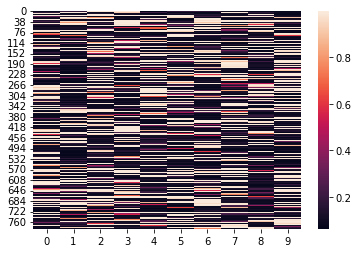

In [79]:
sns.heatmap((torch.sigmoid(model.ul.L_theta)).cpu().detach())

<AxesSubplot:>

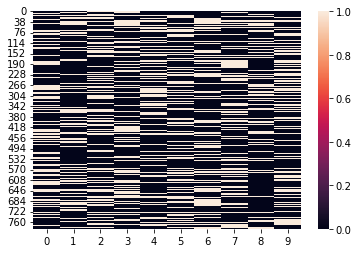

In [80]:
sns.heatmap((torch.sigmoid(model.ul.L_theta) > 0.5).cpu().detach())

In [ ]:
plotted = set()
fig, axes = plt.subplots(2, 10, figsize=(30, 6))
for j in range(6000):
    idx = indices[j]
    lab = labels_[idx]

    if lab not in plotted:
        plotted.add(lab)

        axes[0, lab].imshow(vectors[idx].detach().cpu().view(28,28))

        axes[1, lab].imshow(batch_vectors_affine[j].detach().cpu().view(28,28))

    if len(plotted) == 10:
        break
os.makedirs("result-eca-2023-v2/", exist_ok=True)
plt.savefig("result-eca-2023-v2/all_digits.png")

In [ ]:
fig, axes = plt.subplots(20, 10, figsize=(30, 60))
row_idx = np.zeros((10,), dtype=int)
for j in range(6000):
    idx = indices[j]
    lab = labels_[idx]

    if row_idx[lab] == 10:
        continue
        
    
    # print(lab, row_idx[lab], idx)

    axes[lab*2, row_idx[lab]].imshow(vectors[idx].detach().cpu().view(28,28))

    axes[lab*2+1, row_idx[lab]].imshow(batch_vectors_affine[j].detach().cpu().view(28,28))
    
    row_idx[lab] += 1


os.makedirs("result-eca-2023-v2/", exist_ok=True)
plt.savefig("result-eca-2023-v2/all_digits_10.png")

In [ ]:
[1]

In [ ]:
idx = 60
plt.imshow(vectors[indices][idx].view(28,28))

In [ ]:
plt.imshow(batch_vectors_affine[idx].view(28, 28).detach().cpu())

In [ ]:
import matplotlib.pyplot as plt
plt.plot([l.detach().cpu() for l in loss_all])
plt.title("Loss")

In [ ]:
plt.plot([a.detach().cpu() for a in acc_all])
plt.title("Acc")

In [ ]:
# model_trace = torch.jit.trace(model, (vectors[:batch_size]).to(device=device))

In [ ]:
# model_trace((vectors[:batch_size]).to(device=device))

In [ ]:
sns.heatmap(sigmoid(model.ul.L_theta).detach().cpu())

In [ ]:
fig = plt.figure(dpi=500)
sns.heatmap(sigmoid(model.ul.L_theta).detach().cpu()>0.5)

In [ ]:
fig = plt.figure(dpi=500)
sns.heatmap(sigmoid(model.ul.L_theta.detach().cpu())>0.5)

In [ ]:
y, x = torch.triu_indices(n_vector, n_vector)
U_last = torch.zeros((n_vector, n_vector)).to(device=device)
U_last.index_put_(
    [
        y,
        x
    ],
    model_trace.ul_.A
)
U_last = U_last - U_last.T + torch.diag(torch.diagonal(U_last))
U_last = torch.matrix_exp(U_last)

In [ ]:
ecmm = (sigmoid(model.ul.L_theta).detach().cpu()>0.5).long()

In [ ]:

for j in range(n_class):
    os.makedirs(f"eigen-features-affine-hard-v2/{j}", exist_ok=True)
    for i in range(28*28):
        if ecmm[i, j] == 1:
            io.imsave(f"eigen-features-affine-hard-v2/{j}/ef-{i}.png", U_last[:, i].detach().cpu().view(28, 28))

In [ ]:
# def load_model(model_root):
#     predict_position_path = os.path.join(model_root, "predict_position.pt")
#     predict_media_path = os.path.join(model_root, "predict_media.pt")
#     optim_path = os.path.join(model_root, "optim.pt")
#     model_path = os.path.join(model_root, "mymodel.pt")

    
#     predict_position.load_state_dict(torch.load(predict_position_path))
#     predict_media.load_state_dict(torch.load(predict_media_path))
    

#     optimizer.load(optim_path)

#     pyro.get_param_store().load(model_path)
    
def save_model(model_root):
    os.makedirs(model_root, exist_ok=True)
    
    # predict_position_path = os.path.join(model_root, "predict_position.pt")
    # predict_media_path = os.path.join(model_root, "predict_media.pt")
    # optim_path = os.path.join(model_root, "optim.pt")
    model_path = os.path.join(model_root, "mymodel.pt")
    
    # torch.save(predict_position.state_dict(), predict_position_path)
    # torch.save(predict_media.state_dict(), predict_media_path)

    # optimizer.save(optim_path)

    # pyro.get_param_store().save(model_path)
    torch.save(model.ul.state_dict(), model)

In [ ]:
save_model("eca_sw_mean_sample")

In [ ]:
1+1